<a href="https://colab.research.google.com/github/corentin-pujol/q-Obesity-types-prediction/blob/main/Obesity_levels_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Projet de Quentin PELET & Corentin PUJOL

Import of the different libraries that we will use for data visualisation, analysis and prediction:



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

Transformation of the csv file into a dataframe and deletion of lines containing Nan values:

In [3]:
url = "/content/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(url)
df_copie = pd.read_csv(url)
df.dropna(inplace=True)
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.000000,1.620000,64.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,0.000000,1.000000,no,Public_Transportation,Normal_Weight
1,Female,21.000000,1.520000,56.000000,yes,no,3.0,3.0,Sometimes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.000000,1.800000,77.000000,yes,no,2.0,3.0,Sometimes,no,2.000000,no,2.000000,1.000000,Frequently,Public_Transportation,Normal_Weight
3,Male,27.000000,1.800000,87.000000,no,no,3.0,3.0,Sometimes,no,2.000000,no,2.000000,0.000000,Frequently,Walking,Overweight_Level_I
4,Male,22.000000,1.780000,89.800000,no,no,2.0,1.0,Sometimes,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,Female,20.976842,1.710730,131.408528,yes,yes,3.0,3.0,Sometimes,no,1.728139,no,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,Female,21.982942,1.748584,133.742943,yes,yes,3.0,3.0,Sometimes,no,2.005130,no,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,Female,22.524036,1.752206,133.689352,yes,yes,3.0,3.0,Sometimes,no,2.054193,no,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,Female,24.361936,1.739450,133.346641,yes,yes,3.0,3.0,Sometimes,no,2.852339,no,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


Changed the names of some columns to have a better visibility of their meaning and displayed a consistent description of the different information in the dataframe.

In [4]:
col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

Columns names description :

FAVC -> Frequent consumption of high caloric food 

FCVC -> Frequency of consumption of vegetables

NCP -> Number of main daily meals

CAEC -> Consumption of food between meals

CH2O -> Consumption of water daily

SCC -> Does the person count how many calories he consums daily

FAF -> Physical usual activity 

TUE -> How many times the person spends on a screen daily

CALC -> Usual alcohol consumption




Now, we are going to tranform all the qualitative variables as quantitative variables (Gender, Family overweight, FAVC, CAEC, Smoke, SCC, CALC, Transportation, Obesity level category)

Age : We truncate the values to the unit

And for the other variables, we decided to round the values because we thought that it didn't make sense to have six or seven numbers after the comma.

In [5]:
df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,0))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,0))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)
# df["Transportation"], unique_Transportation = pd.factorize(df["Transportation"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,Normal_Weight
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,Normal_Weight
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,Normal_Weight
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,Overweight_Level_I
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,Obesity_Type_III
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,Obesity_Type_III
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,Obesity_Type_III


Transformation of the quantitative types of obesity level categories into numerical values, in order to study the correlation matrix, in the next part.

In [6]:
obesity_level ={"Insufficient_Weight": 0, "Normal_Weight": 1, "Overweight_Level_I": 2, "Overweight_Level_II": 3, "Obesity_Type_I": 4, "Obesity_Type_II": 5, "Obesity_Type_III": 6}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : int(x))

df

,Gender,Age,Height,Weight,Family_overweight,FAVC,FCVC,NCP,CAEC,Smoke,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,64.0,1,0,2,3,2,0,2.0,0,0,1.0,3,4,1
1,1,21,1.52,56.0,1,0,3,3,2,1,3.0,1,3,0.0,2,4,1
2,0,23,1.80,77.0,1,0,2,3,2,0,2.0,0,2,1.0,1,4,1
3,0,27,1.80,87.0,0,0,3,3,2,0,2.0,0,2,0.0,1,5,2
4,0,22,1.78,89.8,0,0,2,1,2,0,2.0,0,0,0.0,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,131.4,1,1,3,3,2,0,2.0,0,2,1.0,2,4,6
2107,1,21,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2108,1,22,1.75,133.7,1,1,3,3,2,0,2.0,0,1,1.0,2,4,6
2109,1,24,1.74,133.3,1,1,3,3,2,0,3.0,0,1,1.0,2,4,6


#Visualization of the data and correlation

The correlation matrix of the different variables in the dataset is plotted below in order to visualise which variables are more or less correlated with the obesity level category.

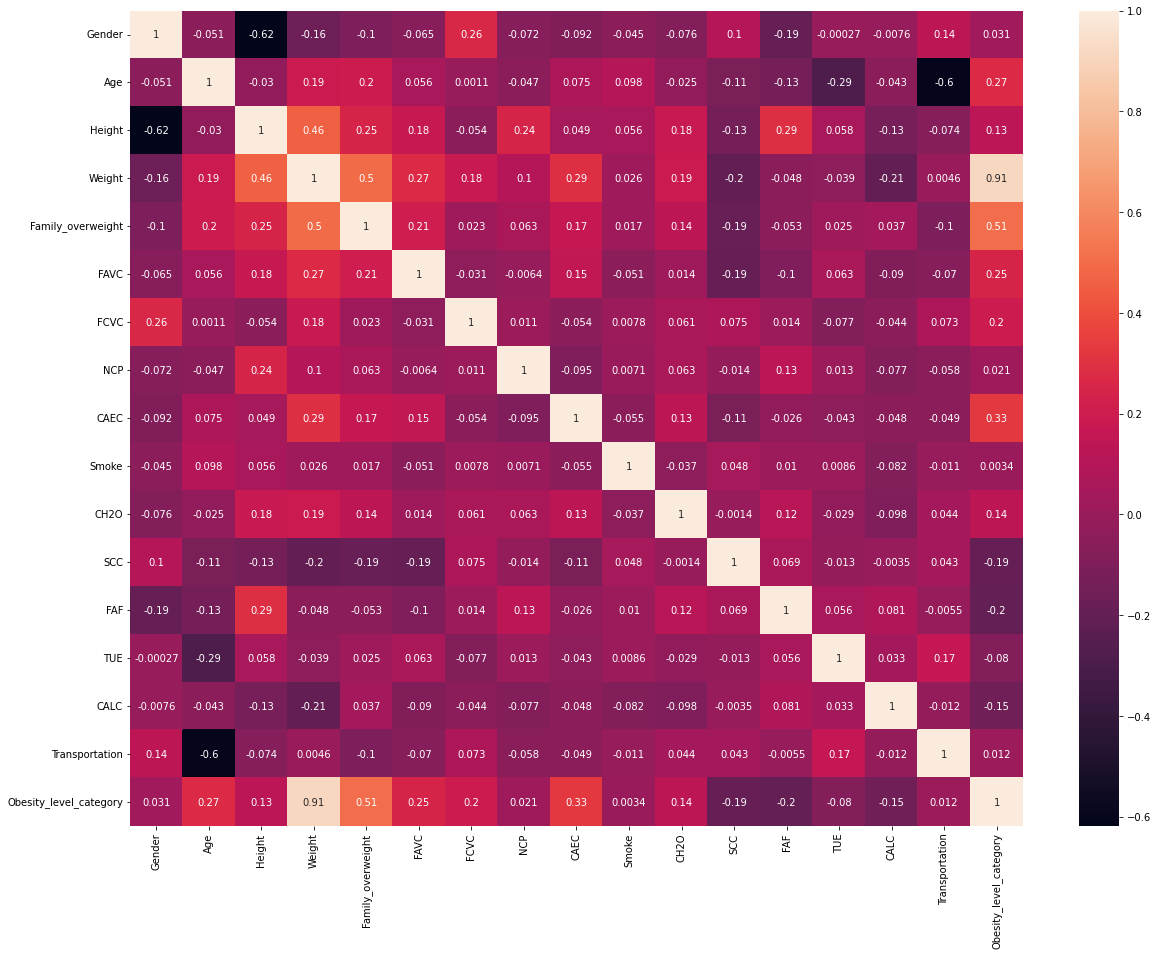

In [7]:
corr_df = df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

We notice that the variable Weight is highly correlated with the level of obesity, which is logical since weight is very determinant in determining the level of obesity with the BMI.

We also notice that some variables have very little influence on the level of obesity, which is the case for example with the variables Smoke, Gender, NCP, or even the variable Transportation.

Let us now study the distribution of the data in more details to determine whether certain columns are biased with respect to the representation of a normal population. Indeed, if we wish to set up a generalizable study and prediction model, we must work on a sample that is as representative as possible of the reality.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff6b3978b90>,
      dtype=object)

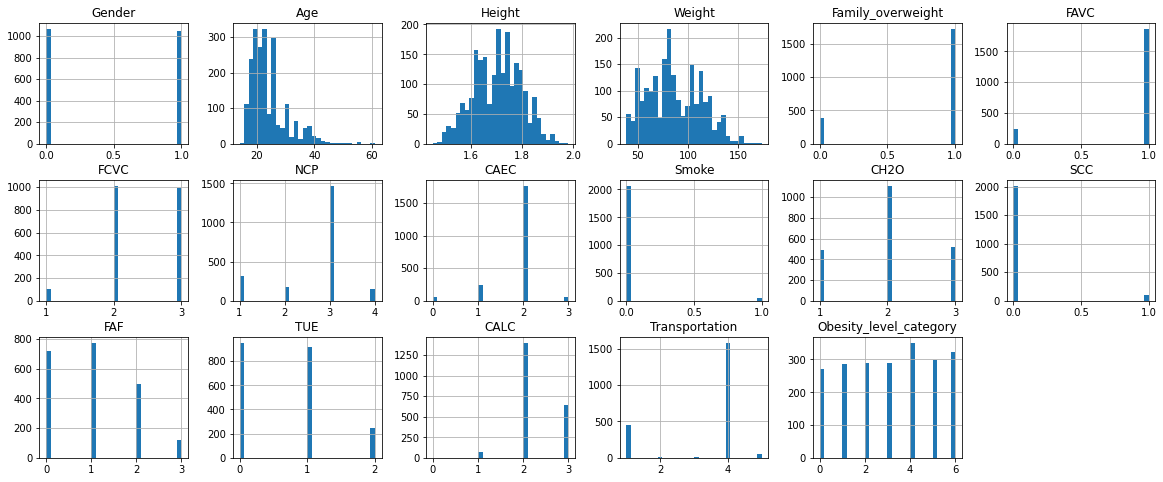

In [8]:
df[col_names].hist(bins=30, figsize=(20, 8), layout=(3, 6))

Although the age curve shows us that the sample is quite young, we see that there are as many men and women of different heights and weights. The sample is well representative of a real population.

Moreover, there is a homogeneous distribution of the different categories of obesity.

However, we can notice something quite surprising in the "Smoke" variable:

In [9]:
df.groupby("Smoke").count()["Gender"]

Smoke
0    2067
1      44
Name: Gender, dtype: int64

We can see that 2% of our sample is a smoker, which is not representative of the number of people who smoke in South America. For example, 16% of the adult population smokes in Mexico, which is considerably more. 

Because there are not enough smokers in the sample, we doubt its true impact on obesity in this study, and we decide to remove the variable from the dataset.

In [10]:
df.drop(['Smoke'],axis = 1, inplace = True)

Nous pouvons aussi observer plus haut une répartition assez inégale au niveau des moyens de transport. 

In [11]:
df_copie.groupby("MTRANS").count()["Gender"]

MTRANS
Automobile                457
Bike                        7
Motorbike                  11
Public_Transportation    1580
Walking                    56
Name: Gender, dtype: int64

We can see that this variable tells us whether an individual uses a means of transport that requires physical effort (walking or cycling) or not (car, bus or motorbike). In order for this variable to have a greater impact on the prediction of obesity levels, by having a distinct boundary, we have chosen to transform the column by grouping together means of transport requiring physical effort and those not requiring any.

Thus, cars, motorbikes and public transport (categories 1, 3 and 4) will be categorised as 0 as they produce no physical effort, while walking and cycling (categories 2 and 5) will be categorised as 1.

In [12]:
df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

# df.groupby(by=df['Transportation']).count()['Gender']

We are going now, to plot different pairwise relationships in this dataset, in order to see if there are other interesting things to take into account.

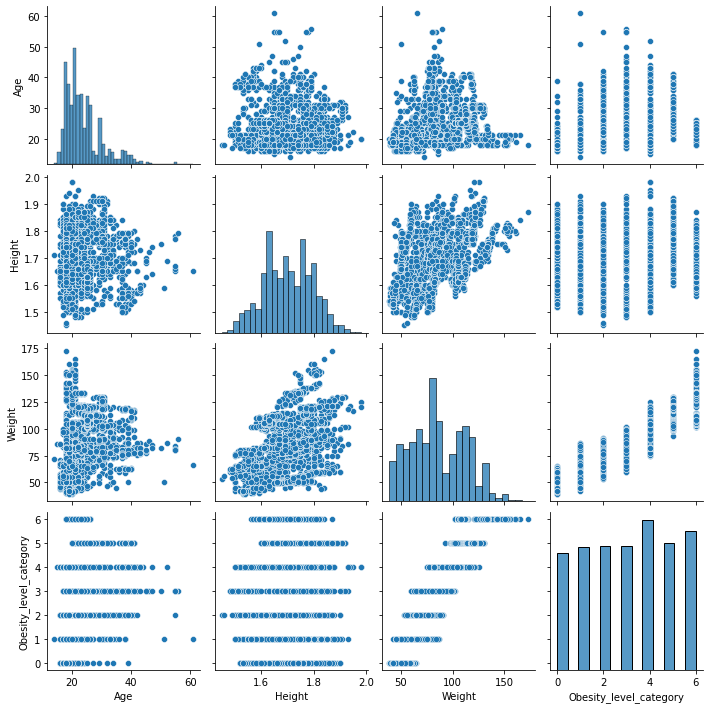

In [13]:
sns.pairplot(df[["Age","Height","Weight","Obesity_level_category"]])

It can be seen that as a person's weight increases, so does their level of obesity. 
Furthermore, height does not influence the level of obesity

This confirms that the BMI, to determine the level of obesity, is calculated from the weight of a person

To allow the models to take more account of the other variables, we have decided to remove the Weight variable from the dataframe. We will still try different models with it in place for comparison purposes.

**PS: compare the accuracy of models with and without Weight**

In [14]:
df.drop(['Weight'],axis = 1, inplace = True)

# Model prediction

x:variables de predictions
y:target variable

In [ ]:
# x=df.loc[:,df.columns!="Obesity_level_category"]
# y=df.loc[:,df.columns=="Obesity_level_category"]

Scale des données

In [ ]:
# scaler=StandardScaler()
# scaler.fit(x)
# x_scaled=scaler.transform(x)

Split en train_set et en test_set

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
# print(x_train.shape)
# print(x_test.shape)
# print(y_train.shape)
# print(y_test.shape)

1. KNN
2. SVM
3. Boosting
4. Random Forest
5. Logistic Regression 
6. LDA/QDA




#Linear Discriminant Analysis

##All classes

In [15]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Normal_Weight
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Normal_Weight
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Normal_Weight
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Overweight_Level_I
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obesity_Type_III
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obesity_Type_III
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obesity_Type_III
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obesity_Type_III


In [16]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

In [17]:
scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)
x_train

array([[-0.98822657, -0.15419354,  0.51828431, ...,  0.18414996,
        -0.52115952, -0.17539019],
       [-0.98822657, -0.78839242, -0.23161163, ...,  0.90686873,
         1.4191716 , -0.17539019],
       [ 1.01191369,  1.58985335, -0.23161163, ..., -1.08060789,
        -0.52115952, -0.17539019],
       ...,
       [ 1.01191369,  2.22405222, -1.9456595 , ..., -1.08060789,
        -0.52115952, -0.17539019],
       [-0.98822657,  0.32145561,  1.26818026, ..., -0.30861284,
         1.4191716 , -0.17539019],
       [-0.98822657,  0.95565448,  2.23233218, ...,  0.52908392,
        -0.52115952, -0.17539019]])

In [19]:
parameters = {"solver": ["svd", "lsqr", "eigen"], "shrinkage": ["None", "auto"], "n_components" :["None", 5, 10, 15]}

In [20]:
lda = LinearDiscriminantAnalysis()

Implementation of cross-validation methods to assess the performance of the models:

In [21]:
def validation_curve_function(model, x, y, paramater, k):
  train_scores, val_scores=validation_curve(model,x , y, param_range=k, cv=5, param_name=paramater)
  plt.plot(k, val_scores.mean(axis=1))
  plt.plot(k, train_scores.mean(axis=1))

def cross_val_function(model, x, y):
  print(cross_val_score(model, x, y))

cross_val_function(lda, x_train, y_train)

[0.55830389 0.56537102 0.58303887 0.50530035 0.58510638]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
grid_search = GridSearchCV(estimator=lda,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=None, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=None, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=5, s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.569 total time=   0.0s
[CV 2/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.541 total time=   0.0s
[CV 3/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.516 total time=   0.0s
[CV 4/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.527 total time=   0.0s
[CV 5/5] END n_components=5, shrinkage=auto, solver=eigen;, score=0.528 total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=None, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=None, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_c

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END n_components=10, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=None, solver=eigen;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 4/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 5/5] END n_components=10, shrinkage=auto, solver=svd;, score=nan total time=   0.0s
[CV 1/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 2/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 3/5] END n_components=10, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 4/5] END n_componen

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END n_components=15, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 5/5] END n_components=15, shrinkage=auto, solver=lsqr;, score=nan total time=   0.0s
[CV 1/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 2/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 3/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 4/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s
[CV 5/5] END n_components=15, shrinkage=auto, solver=eigen;, score=nan total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
110 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/

GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(),
             param_grid={'n_components': ['None', 5, 10, 15],
                         'shrinkage': ['None', 'auto'],
                         'solver': ['svd', 'lsqr', 'eigen']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'n_components': 5, 'shrinkage': 'auto', 'solver': 'lsqr'}

In [ ]:
lda=LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto", n_components=5)

In [ ]:
model=lda.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model.coef_

array([[ 0.36462142, -0.89943083,  0.02490442, -1.26044036, -0.05241441,
         0.17157791,  0.344501  , -0.90319502, -0.25431319,  0.01376207,
         0.29788407,  0.1811842 ,  0.38955069, -0.10165596],
       [-0.2517838 , -0.37903392, -0.36322679, -0.98886342, -0.30252584,
        -0.30423656, -0.02052204, -1.15121579, -0.29937784,  0.06000245,
         0.51071982, -0.04653102,  0.07910412,  0.51913347],
       [-0.16784218,  0.33084721, -0.22707024,  0.54879688,  0.17314738,
        -0.53001445, -0.38368383,  0.1668992 ,  0.17969365, -0.11850374,
        -0.01426697,  0.02161273,  0.30653118, -0.09349523],
       [-1.38197094,  0.77532753,  0.48413063,  0.48121099,  0.11947162,
         0.11015465, -0.27453434,  0.30514364, -0.50486221,  0.01484038,
        -0.21067371, -0.14151614,  0.00316445, -0.18390251],
       [ 1.85443435, -0.51225311,  0.19584216,  0.69326288,  0.42971581,
         1.29082076,  0.65410124,  0.58148996,  0.4699779 , -0.31944125,
        -0.49353002, -0.06

In [ ]:
coef_fonctions_de_classement = pd.DataFrame(model.coef_.transpose(), index=df.columns[:-1], columns=model.classes_)
coef_fonctions_de_classement

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Gender,0.364621,-0.251784,-0.167842,-1.381971,1.854434,-0.049439,-0.540430
Age,-0.899431,-0.379034,0.330847,0.775328,-0.512253,-0.231169,0.646727
Height,0.024904,-0.363227,-0.227070,0.484131,0.195842,-0.260099,-0.036005
Family_overweight,-1.260440,-0.988863,0.548797,0.481211,0.693263,-0.183703,0.490850
FAVC,-0.052414,-0.302526,0.173147,0.119472,0.429716,0.219477,-0.588239
FCVC,0.171578,-0.304237,-0.530014,0.110155,1.290821,-0.404178,-0.395932
NCP,0.344501,-0.020522,-0.383684,-0.274534,0.654101,-0.200192,-0.334763
CAEC,-0.903195,-1.151216,0.166899,0.305144,0.581490,0.555846,0.139289
CH2O,-0.254313,-0.299378,0.179694,-0.504862,0.469978,0.214470,-0.058729
SCC,0.013762,0.060002,-0.118504,0.014840,-0.319441,0.400581,-0.125212


In [ ]:
print(model.intercept_) #constantes des fonctions de classement

[-3.53281521 -3.44580054 -2.21478447 -3.2784854  -4.33648656 -2.41670123
 -2.53132235]


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_II        153
Obesity_Type_III       149
Obesity_Type_I         147
Insufficient_Weight     86
Normal_Weight           61
Overweight_Level_I      54
Overweight_Level_II     47
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_all

55.38020086083214

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.56890459 0.54063604 0.51590106 0.52650177 0.52836879]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

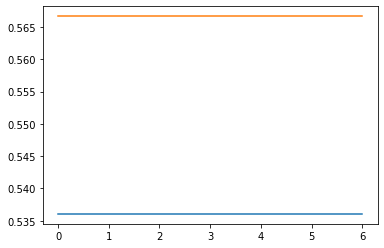

In [ ]:
cross_val_function(lda, x_train, y_train)
validation_curve_function(lda, x_train, y_train, "n_components", np.arange(0,16,1))

It is difficult to be very precise with the 7 types of obesity as the dataset contains only 300 data for each type which seems relatively small to generalise the model.

Let's try to simplify the model by trying to predict only if an individual is obese or not.

##Binary classification using logistic regression

We will now try to simply predict whether an individual is obese or not.

We will re-transform the dataset, so that we have only two classes: 

* Obese people (types 1, 2 and 3)
* The others (Underweight, normal, overweight 1 and 2)



In [ ]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)
y["Obesity_level_category"]

0       Not obese
1       Not obese
2       Not obese
3       Not obese
4       Not obese
          ...    
2106        Obese
2107        Obese
2108        Obese
2109        Obese
2110        Obese
Name: Obesity_level_category, Length: 2111, dtype: object

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
lg = LogisticRegression()

parameters = {"penalty" : ['l1', 'l2', 'elasticnet', 'none'], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "C": [10, 1.0, 0.1, 0.01]}

In [ ]:
cross_val_function(lg, x_train, y_train)

[0.75265018 0.75618375 0.7844523  0.78091873 0.71631206]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
grid_search = GridSearchCV(estimator=lg,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END ..C=10, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ......C=10, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=10, penalty=l1, solver=liblinear;, score=0.756 total time=   0.0s
[CV 2/5] END C=10, penalty=l1, solver=liblinear

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=10, penalty=l2, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 2/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.781 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=10, penalty=l2, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.784 total time=   0.0s
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.781 total time=   0.0s
[CV 5/5] END C=10, penalty=l2, solver=liblinear;, score=0.716 total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=10, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=10, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 3/5] END C=10, penalty=none, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 4/5] END C=10, penalty=none, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=10, penalty=none, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 2/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END ..C=10, penalty=none, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=10, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=10, pen

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d


[CV 5/5] END .C=1.0, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END .....C=1.0, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.753 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.767 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.781 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.781 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l1, solver=liblinear;, score=0.716 total time=   0.0s
[CV 1/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.753 total time=   0.0s
[CV 2/5] END C=1.0, p

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END C=1.0, penalty=l2, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.0s
[CV 2/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.753 total time=   0.0s
[CV 2/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s
[CV 3/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.784 total time=   0.0s
[CV 4/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.781 total time=   0.0s
[CV 5/5] END C=1.0, penalty=l2, solver=liblinear;, score=0.716 total time=   0.0s
[CV 1/5] END C=1.0, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.756 total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.756 total time=   0.1s
[CV 3/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END .C=1.0, penalty=none, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END .C=0.1, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END .C=0.1, pe

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.753 total time=   0.0s
[CV 3/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=newton-cg;, score=0.713 total time=   0.0s
[CV 1/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.0s
[CV 2/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.753 total time=   0.0s
[CV 3/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 4/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END ...C=0.1, penalty=l2, solver=lbfgs;, score=0.713 total time=   0.0s
[CV 1/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.753 total time=   0.0s
[CV 2/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.777 total time=   0.0s
[CV 4/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.1, penalty=l2, solver=liblinear;, score=0.713 total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=elasticnet, solver=lbfgs;, score=n

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 4/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 2/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END .C=0.1, penalty=none, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.1, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/d


[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.696 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.700 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.678 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.703 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.699 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.763 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.749 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.770 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.770 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=newton-cg;, score=0.709 total time=   0.0s
[CV 1/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.763 total time=   0.0s
[CV 2/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.749 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.770 total time=   0.0s
[CV 4/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.770 total time=   0.0s
[CV 5/5] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.709 total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.749 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.742 total time=   0.0s
[CV 3/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.777 total time=   0.0s
[CV 4/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.774 total time=   0.0s
[CV 5/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.706 total time=   0.0s
[CV 1/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=elasticnet, solver=newton-cg;, score=nan total

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

[CV 3/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.784 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=newton-cg;, score=0.716 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.756 total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.784 total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.781 total time=   0.0s
[CV 5/5] END C=0.01, penalty=none, solver=lbfgs;, score=0.716 total time=   0.0s
[CV 1/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=none, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio parameters"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/d

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
lg = LogisticRegression(penalty='l2', C=0.01, solver='newton-cg')

In [ ]:
model = lg.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obese        390
Not obese    307
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_lda_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_lda_bin

71.73601147776183

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

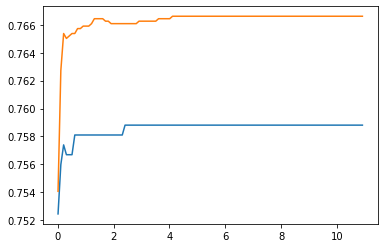

In [ ]:
validation_curve_function(LogisticRegression(), x_train, y_train, "C", np.arange(0.01,11,0.1))

The logistic regression allows us to determine at 77% whether a person is obese or not.

The accuracy of the model increased by about 23% using only the 2 class model. This increase in accuracy is explained by the fact that when we had 7 different classes in the data set the boundaries between classes were not precise because the data overlapped and therefore the model was wrong on a large part of the predictions. However, by simplifying the model and grouping them into only 2 classes the algorithm is able to distinguish the boundaries between classes better and better.

#Knn

We will now try to use the K-nearest neighbors algorithm to see if we can increase the accuracy of predictions.

##All classes

In [ ]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [ ]:
cross_val_function(knn, x_train, y_train)

[0.71731449 0.78091873 0.69611307 0.75265018 0.74113475]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.770 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.686 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.739 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.748 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.784 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.717 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.696 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.753 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.741 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.746 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.784 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.707 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.678 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.734 total time=   0.1s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.770 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.700 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.728 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.650 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.730 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.728 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.767 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.686 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.766 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.700 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.640 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.717 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.723 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.735 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.760 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.777 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.707 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.633 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.696 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.706 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.724 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.773 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.707 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.618 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.693 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.706 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.731 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.753 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.671 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.618 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.678 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.677 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.728 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.753 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.661 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.735 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.748 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.678 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.671 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.597 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.668 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.660 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.717 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.724 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.654 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.735 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.734 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.770 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.788 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.721 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.774 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.784 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.830 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.753 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.739 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.784 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.728 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.756 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.762 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.763 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.806 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.742 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.777 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.801 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.760 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.717 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.742 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.745 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.774 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.795 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.746 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.774 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.791 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.742 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.749 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.693 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.724 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.748 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.802 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.731 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.777 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.794 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.724 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.717 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.682 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.724 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.745 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.788 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.717 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.770 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.798 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.707 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.703 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.661 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.707 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.738 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.689 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.787 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.703 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.689 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.650 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.689 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.730 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.756 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.739 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.689 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.742 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.780 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.696 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.668 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.629 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.703 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.720 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.735 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.693 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.787 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.686 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.664 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.629 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.696 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.699 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.746 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.731 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.675 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.753 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.759 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.721 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.770 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.686 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.739 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.748 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.749 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.788 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.721 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.784 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.717 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.781 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.696 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.753 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.741 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.746 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.784 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.707 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.728 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.731 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.678 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.721 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.734 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.760 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.770 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.700 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.767 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.728 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.650 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.730 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.728 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.767 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.686 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.756 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.766 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.700 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.721 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.640 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.717 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.723 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.735 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.760 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.777 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.689 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.707 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.633 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.696 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.706 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.724 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.763 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.756 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.696 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.707 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.618 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.693 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.706 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.731 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.753 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.671 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.749 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.770 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.689 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.618 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.678 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.677 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.728 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.753 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.661 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.735 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.748 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.678 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.671 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.597 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.668 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.660 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.717 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.724 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.654 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.735 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.734 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [ ]:
model = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         122
Obesity_Type_III       113
Obesity_Type_II        112
Insufficient_Weight     96
Overweight_Level_I      89
Overweight_Level_II     84
Normal_Weight           81
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_all

80.05738880918221

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

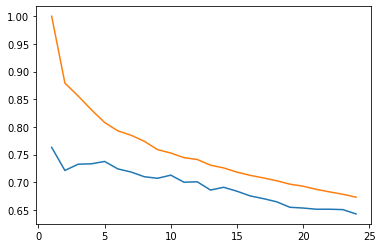

In [ ]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

We obtained 82% success in predicting the different types of obesity, which is significantly better than with the LDA model performed above.

Indeed, as the data overlap between the different classes, it is much more efficient and coherent to study the neighbours of an individual in space than to try to draw a border between the different classes.

##Classification binaire

In [ ]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
knn = KNeighborsClassifier()
parameters = {"n_neighbors": range(3, 21, 2), "weights":['uniform', 'distance'], "metric":['euclidean', 'manhattan', 'minkowski']}

In [ ]:
cross_val_function(knn, x_train, y_train)

[0.89045936 0.87279152 0.85865724 0.85865724 0.87234043]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

In [ ]:
grid_search = GridSearchCV(estimator=knn,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.922 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.876 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.852 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.894 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.866 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.901 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=uniform;, score=0.872 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.915 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.873 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.873 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=5, weights=distance;, score=0.887 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.859 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.834 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.855 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=uniform;, score=0.879 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.855 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.869 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=7, weights=distance;, score=0.887 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.866 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.834 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.855 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=uniform;, score=0.858 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.890 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.845 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.866 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.852 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.816 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.837 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=11, weights=distance;, score=0.869 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.827 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.823 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.827 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=uniform;, score=0.833 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.876 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.837 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.855 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=13, weights=distance;, score=0.865 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.816 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=15, weights=uniform;, score=0.833 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.862 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.845 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=euclidean, n_neighbors=15, weights=distance;, score=0.844 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.820 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.852 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.841 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=17, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.806 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.802 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.784 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=uniform;, score=0.809 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.834 total time=   0.0s
[CV 3/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.827 total time=   0.0s
[CV 4/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.837 total time=   0.0s
[CV 5/5] END metric=euclidean, n_neighbors=19, weights=distance;, score=0.830 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.908 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.890 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.873 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=manhattan, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.943 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.912 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.898 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.883 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=3, weights=distance;, score=0.897 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.919 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.890 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.869 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.876 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=uniform;, score=0.876 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.936 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.905 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.890 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.894 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=5, weights=distance;, score=0.897 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.908 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.855 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.859 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.901 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.873 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.887 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=7, weights=distance;, score=0.883 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.915 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.876 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.845 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.845 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=uniform;, score=0.879 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.926 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.890 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.862 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=9, weights=distance;, score=0.901 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.905 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.845 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.837 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.834 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=uniform;, score=0.848 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.876 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.866 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.859 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=11, weights=distance;, score=0.883 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.898 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.869 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.816 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.827 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.915 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.855 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=13, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.848 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.813 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=uniform;, score=0.851 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.845 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.845 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=15, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.898 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.830 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.795 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.784 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=uniform;, score=0.851 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.915 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.876 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.834 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=17, weights=distance;, score=0.872 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.830 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.792 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.770 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=uniform;, score=0.851 total time=   0.0s
[CV 1/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.915 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.869 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.827 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.820 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=19, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 2/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.876 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.852 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=uniform;, score=0.887 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.922 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.894 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.887 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.866 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, weights=distance;, score=0.901 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.873 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.859 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=uniform;, score=0.872 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.915 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.883 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.873 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.873 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=5, weights=distance;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.890 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.859 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.834 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.855 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=uniform;, score=0.879 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.887 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.855 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.869 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=7, weights=distance;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.866 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.834 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.855 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=9, weights=uniform;, score=0.858 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.890 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.845 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.866 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=9, weights=distance;, score=0.876 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.852 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.816 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.841 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=uniform;, score=0.855 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.883 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.837 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.862 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=11, weights=distance;, score=0.869 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.827 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.823 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.827 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=uniform;, score=0.833 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 1/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.901 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.876 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.837 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.855 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=13, weights=distance;, score=0.865 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.887 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.820 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.816 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 5/5] END metric=minkowski, n_neighbors=15, weights=uniform;, score=0.833 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.862 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.845 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=15, weights=distance;, score=0.844 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.820 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 4/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.799 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=uniform;, score=0.823 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.898 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.852 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.834 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.841 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=17, weights=distance;, score=0.840 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.883 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.806 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

[CV 3/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.802 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.784 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=uniform;, score=0.809 total time=   0.0s
[CV 1/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.894 total time=   0.0s
[CV 2/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.834 total time=   0.0s
[CV 3/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.827 total time=   0.0s
[CV 4/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.837 total time=   0.0s
[CV 5/5] END metric=minkowski, n_neighbors=19, weights=distance;, score=0.830 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': range(3, 21, 2),
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [ ]:
model = knn.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Not obese    385
Obese        312
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_knn_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_knn_bin

93.40028694404592

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

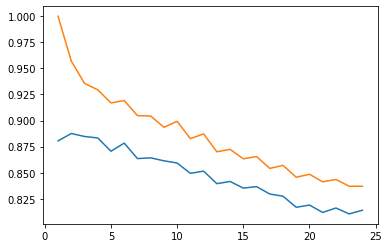

In [ ]:
validation_curve_function(KNeighborsClassifier(), x_train, y_train, "n_neighbors", np.arange(1,25,1))

With the Knn we obtain 92.5% of success on the classification which confirms the conclusion made during the first test of the Knn on all the classes of the dataset.

#SVM

##All classes

In [ ]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [ ]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.72084806 0.7844523  0.74204947 0.75971731 0.70212766]


In [ ]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.731 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.788 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.721 total time=   0.1s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.795 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.752 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s
[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.799 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.399 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.442 total time=   0.1s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.413 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.399 total time=   0.1s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.383 total time=   0.1s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.731 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.792 total time=   0.1s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.721 total time=   0.1s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.792 total time=   0.1s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.755 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.806 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.799 total time=   0.1s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.763 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.777 total time=   0.1s
[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.773 total time=   0.1s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.378 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.445 total time=   0.1s
[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.389 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.392 total time=   0.1s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.358 total time=   0.1s
[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.739 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.781 total time=   0.1s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.735 total time=   0.1s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.752 total time=   0.1s
[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.795 total time=   0.1s
[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.816 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.777 total time=   0.1s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.802 total time=   0.1s
[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.787 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.420 total time=   0.1s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.466 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.389 total time=   0.1s
[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.417 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.394 total time=   0.1s
[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.735 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.781 total time=   0.1s
[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.731 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.788 total time=   0.1s
[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.752 total time=   0.1s
[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.816 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.777 total time=   0.1s
[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.806 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.787 total time=   0.1s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.410 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.459 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.399 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.406 total time=   0.1s
[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.390 total time=   0.1s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.724 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.767 total time=   0.1s
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.717 total time=   0.1s
[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.781 total time=   0.1s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.752 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.799 total time=   0.1s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.802 total time=   0.1s
[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.774 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.795 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.773 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.417 total time=   0.1s
[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.481 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.392 total time=   0.1s
[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.431 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.390 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.724 total time=   0.1s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.714 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.781 total time=   0.1s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.755 total time=   0.1s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.799 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.802 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.774 total time=   0.1s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.795 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.773 total time=   0.1s
[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.410 total time=   0.1s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.491 total time=   0.1s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.378 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.438 total time=   0.1s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.408 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.735 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.784 total time=   0.1s
[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.724 total time=   0.1s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.770 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.720 total time=   0.1s
[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.781 total time=   0.1s
[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s
[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.802 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.762 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.420 total time=   0.1s
[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.466 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.389 total time=   0.1s
[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.452 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.415 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.731 total time=   0.1s
[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.781 total time=   0.1s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.724 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.767 total time=   0.1s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.720 total time=   0.1s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.781 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.809 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.784 total time=   0.1s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.802 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.762 total time=   0.1s
[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.435 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.488 total time=   0.1s
[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.389 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.456 total time=   0.1s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.404 total time=   0.1s
[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.661 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.693 total time=   0.1s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.675 total time=   0.1s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.700 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.660 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.721 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.784 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.742 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.760 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.702 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.466 total time=   0.1s
[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.512 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.428 total time=   0.1s
[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.527 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.461 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.664 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.689 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.675 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.707 total time=   0.1s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.660 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.721 total time=   0.1s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.784 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.742 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.760 total time=   0.1s
[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.706 total time=   0.1s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.456 total time=   0.1s
[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.516 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.435 total time=   0.1s
[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.519 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.472 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.512 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.512 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.491 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.495 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.465 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.590 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.587 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.576 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.583 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.539 total time=   0.2s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.498 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.537 total time=   0.2s
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.481 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.544 total time=   0.2s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.457 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.512 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.512 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.484 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.495 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.468 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.590 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.587 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.576 total time=   0.1s
[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.583 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.539 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.498 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.537 total time=   0.2s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.477 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.544 total time=   0.2s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.454 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.201 total time=   0.1s
[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.212 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.223 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.208 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.202 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s
[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s
[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.177 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.174 total time=   0.3s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.201 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.208 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.223 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.208 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.202 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.173 total time=   0.2s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.170 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.177 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.173 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'C': 25, 'gamma': 'auto', 'kernel': 'rbf'}

In [ ]:
svm_svc = SVC(C=25, gamma='scale', kernel='rbf')
model = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         121
Obesity_Type_III       114
Insufficient_Weight    104
Obesity_Type_II         98
Overweight_Level_II     91
Normal_Weight           87
Overweight_Level_I      82
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_all

80.6312769010043

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

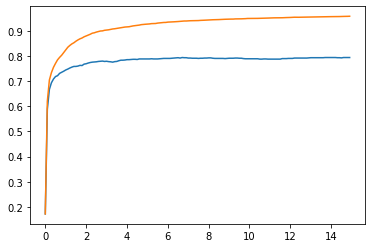

In [ ]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

78% success rate.

##Binary classification

In [ ]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

df

,Gender,Age,Height,Family_overweight,FAVC,FCVC,NCP,CAEC,CH2O,SCC,FAF,TUE,CALC,Transportation,Obesity_level_category
0,1,21,1.62,1,0,2,3,2,2.0,0,0,1.00,3,0,Not obese
1,1,21,1.52,1,0,3,3,2,3.0,1,3,0.00,2,0,Not obese
2,0,23,1.80,1,0,2,3,2,2.0,0,2,1.00,1,0,Not obese
3,0,27,1.80,0,0,3,3,2,2.0,0,2,0.00,1,1,Not obese
4,0,22,1.78,0,0,2,1,2,2.0,0,0,0.00,2,0,Not obese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,1,20,1.71,1,1,3,3,2,1.7,0,2,0.91,2,0,Obese
2107,1,21,1.75,1,1,3,3,2,2.0,0,1,0.60,2,0,Obese
2108,1,22,1.75,1,1,3,3,2,2.1,0,1,0.65,2,0,Obese
2109,1,24,1.74,1,1,3,3,2,2.9,0,1,0.59,2,0,Obese


In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
svm_svc = SVC()
parameters = {"kernel": ['poly', 'rbf', 'sigmoid'], "C": [50, 25, 10, 5, 1.0, 0.1, 0.01], "gamma": ['scale', 'auto']}

In [ ]:
cross_val_function(svm_svc, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[0.86925795 0.87985866 0.86572438 0.85865724 0.86879433]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
grid_search = GridSearchCV(estimator=svm_svc,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END ....C=50, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END ....C=50, gamma=scale, kernel=poly;, score=0.855 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=50, gamma=scale, kernel=poly;, score=0.866 total time=   0.1s
[CV 4/5] END ....C=50, gamma=scale, kernel=poly;, score=0.855 total time=   0.1s
[CV 5/5] END ....C=50, gamma=scale, kernel=poly;, score=0.908 total time=   0.1s
[CV 1/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 3/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.905 total time=   0.1s
[CV 4/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.890 total time=   0.1s
[CV 5/5] END .....C=50, gamma=scale, kernel=rbf;, score=0.918 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.636 total time=   0.1s
[CV 2/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.608 total time=   0.1s
[CV 3/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.650 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.615 total time=   0.1s
[CV 5/5] END .C=50, gamma=scale, kernel=sigmoid;, score=0.603 total time=   0.1s
[CV 1/5] END .....C=50, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .....C=50, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 3/5] END .....C=50, gamma=auto, kernel=poly;, score=0.866 total time=   0.1s
[CV 4/5] END .....C=50, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 5/5] END .....C=50, gamma=auto, kernel=poly;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 2/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 3/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.905 total time=   0.1s
[CV 4/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ......C=50, gamma=auto, kernel=rbf;, score=0.918 total time=   0.1s
[CV 1/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.647 total time=   0.1s
[CV 2/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.594 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.647 total time=   0.1s
[CV 4/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 5/5] END ..C=50, gamma=auto, kernel=sigmoid;, score=0.603 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=25, gamma=scale, kernel=poly;, score=0.873 total time=   0.1s
[CV 2/5] END ....C=25, gamma=scale, kernel=poly;, score=0.862 total time=   0.1s
[CV 3/5] END ....C=25, gamma=scale, kernel=poly;, score=0.873 total time=   0.1s
[CV 4/5] END ....C=25, gamma=scale, kernel=poly;, score=0.845 total time=   0.0s
[CV 5/5] END ....C=25, gamma=scale, kernel=poly;, score=0.897 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 2/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s
[CV 3/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.905 total time=   0.1s
[CV 4/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .....C=25, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 1/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.629 total time=   0.1s
[CV 2/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.597 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.657 total time=   0.1s
[CV 4/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.590 total time=   0.1s
[CV 5/5] END .C=25, gamma=scale, kernel=sigmoid;, score=0.628 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .....C=25, gamma=auto, kernel=poly;, score=0.873 total time=   0.1s
[CV 2/5] END .....C=25, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 3/5] END .....C=25, gamma=auto, kernel=poly;, score=0.873 total time=   0.1s
[CV 4/5] END .....C=25, gamma=auto, kernel=poly;, score=0.848 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .....C=25, gamma=auto, kernel=poly;, score=0.897 total time=   0.1s
[CV 1/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s
[CV 2/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.890 total time=   0.1s
[CV 3/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.905 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.887 total time=   0.1s
[CV 5/5] END ......C=25, gamma=auto, kernel=rbf;, score=0.911 total time=   0.1s
[CV 1/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.629 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.608 total time=   0.1s
[CV 3/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.671 total time=   0.1s
[CV 4/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.608 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ..C=25, gamma=auto, kernel=sigmoid;, score=0.610 total time=   0.1s
[CV 1/5] END ....C=10, gamma=scale, kernel=poly;, score=0.859 total time=   0.1s
[CV 2/5] END ....C=10, gamma=scale, kernel=poly;, score=0.876 total time=   0.0s
[CV 3/5] END ....C=10, gamma=scale, kernel=poly;, score=0.841 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 4/5] END ....C=10, gamma=scale, kernel=poly;, score=0.820 total time=   0.1s
[CV 5/5] END ....C=10, gamma=scale, kernel=poly;, score=0.876 total time=   0.0s
[CV 1/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.901 total time=   0.1s
[CV 2/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s
[CV 5/5] END .....C=10, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.625 total time=   0.1s
[CV 2/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.625 total time=   0.1s
[CV 3/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.611 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.625 total time=   0.1s
[CV 5/5] END .C=10, gamma=scale, kernel=sigmoid;, score=0.606 total time=   0.1s
[CV 1/5] END .....C=10, gamma=auto, kernel=poly;, score=0.862 total time=   0.1s
[CV 2/5] END .....C=10, gamma=auto, kernel=poly;, score=0.873 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=10, gamma=auto, kernel=poly;, score=0.841 total time=   0.1s
[CV 4/5] END .....C=10, gamma=auto, kernel=poly;, score=0.827 total time=   0.0s
[CV 5/5] END .....C=10, gamma=auto, kernel=poly;, score=0.876 total time=   0.0s
[CV 1/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s
[CV 3/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.915 total time=   0.1s
[CV 4/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s
[CV 5/5] END ......C=10, gamma=auto, kernel=rbf;, score=0.904 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.629 total time=   0.1s
[CV 2/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.611 total time=   0.1s
[CV 3/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.618 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.633 total time=   0.1s
[CV 5/5] END ..C=10, gamma=auto, kernel=sigmoid;, score=0.656 total time=   0.1s
[CV 1/5] END .....C=5, gamma=scale, kernel=poly;, score=0.848 total time=   0.1s
[CV 2/5] END .....C=5, gamma=scale, kernel=poly;, score=0.869 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 3/5] END .....C=5, gamma=scale, kernel=poly;, score=0.834 total time=   0.0s
[CV 4/5] END .....C=5, gamma=scale, kernel=poly;, score=0.834 total time=   0.0s
[CV 5/5] END .....C=5, gamma=scale, kernel=poly;, score=0.851 total time=   0.0s
[CV 1/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.912 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.883 total time=   0.1s
[CV 3/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.908 total time=   0.1s
[CV 4/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.887 total time=   0.1s
[CV 5/5] END ......C=5, gamma=scale, kernel=rbf;, score=0.904 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.661 total time=   0.1s
[CV 2/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.618 total time=   0.1s
[CV 3/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.654 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.601 total time=   0.1s
[CV 5/5] END ..C=5, gamma=scale, kernel=sigmoid;, score=0.631 total time=   0.1s
[CV 1/5] END ......C=5, gamma=auto, kernel=poly;, score=0.848 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ......C=5, gamma=auto, kernel=poly;, score=0.869 total time=   0.1s
[CV 3/5] END ......C=5, gamma=auto, kernel=poly;, score=0.834 total time=   0.0s
[CV 4/5] END ......C=5, gamma=auto, kernel=poly;, score=0.830 total time=   0.0s
[CV 5/5] END ......C=5, gamma=auto, kernel=poly;, score=0.851 total time=   0.0s
[CV 1/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.883 total time=   0.1s
[CV 3/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.908 total time=   0.1s
[CV 4/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.887 total time=   0.1s
[CV 5/5] END .......C=5, gamma=auto, kernel=rbf;, score=0.901 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.650 total time=   0.1s
[CV 2/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.650 total time=   0.1s
[CV 4/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.625 total time=   0.1s
[CV 5/5] END ...C=5, gamma=auto, kernel=sigmoid;, score=0.631 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.788 total time=   0.1s
[CV 2/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.852 total time=   0.0s
[CV 3/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.813 total time=   0.0s
[CV 4/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.806 total time=   0.0s
[CV 5/5] END ...C=1.0, gamma=scale, kernel=poly;, score=0.823 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.869 total time=   0.1s
[CV 2/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.880 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.866 total time=   0.1s
[CV 4/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.859 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END ....C=1.0, gamma=scale, kernel=rbf;, score=0.869 total time=   0.1s
[CV 1/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.696 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.689 total time=   0.1s
[CV 3/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.664 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.654 total time=   0.1s
[CV 5/5] END C=1.0, gamma=scale, kernel=sigmoid;, score=0.699 total time=   0.1s
[CV 1/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.788 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.855 total time=   0.1s
[CV 3/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.816 total time=   0.0s
[CV 4/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.806 total time=   0.0s
[CV 5/5] END ....C=1.0, gamma=auto, kernel=poly;, score=0.823 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.869 total time=   0.1s
[CV 2/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.880 total time=   0.1s
[CV 3/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.866 total time=   0.1s
[CV 4/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.862 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 5/5] END .....C=1.0, gamma=auto, kernel=rbf;, score=0.872 total time=   0.1s
[CV 1/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.693 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.678 total time=   0.1s
[CV 3/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.664 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.650 total time=   0.1s
[CV 5/5] END .C=1.0, gamma=auto, kernel=sigmoid;, score=0.695 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.717 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.703 total time=   0.1s
[CV 3/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.746 total time=   0.1s
[CV 4/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.700 total time=   0.1s
[CV 5/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.745 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.823 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.820 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.781 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.774 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.809 total time=   0.1s
[CV 1/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.739 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.749 total time=   0.1s
[CV 3/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.749 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.689 total time=   0.1s
[CV 5/5] END C=0.1, gamma=scale, kernel=sigmoid;, score=0.734 total time=   0.1s
[CV 1/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.717 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.707 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.746 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.703 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=auto, kernel=poly;, score=0.752 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.823 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.820 total time=   0.1s
[CV 3/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.781 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.774 total time=   0.1s
[CV 5/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.809 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.735 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.746 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.746 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.696 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=auto, kernel=sigmoid;, score=0.730 total time=   0.1s
[CV 1/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.555 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.555 total time=   0.1s
[CV 3/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.555 total time=   0.1s
[CV 4/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.555 total time=   0.1s
[CV 5/5] END ..C=0.01, gamma=scale, kernel=poly;, score=0.557 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 1/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.587 total time=   0.1s
[CV 2/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.597 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.569 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.604 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.592 total time=   0.1s
[CV 1/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.562 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.548 total time=   0.1s
[CV 3/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.548 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.594 total time=   0.1s
[CV 5/5] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.582 total time=   0.1s
[CV 1/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.555 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[CV 2/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.555 total time=   0.1s
[CV 3/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.555 total time=   0.1s
[CV 4/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.555 total time=   0.1s
[CV 5/5] END ...C=0.01, gamma=auto, kernel=poly;, score=0.557 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.597 total time=   0.1s
[CV 2/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.597 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.569 total time=   0.1s
[CV 4/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.608 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END ....C=0.01, gamma=auto, kernel=rbf;, score=0.592 total time=   0.1s
[CV 1/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.562 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.548 total time=   0.1s
[CV 3/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.548 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.608 total time=   0.1s
[CV 5/5] END C=0.01, gamma=auto, kernel=sigmoid;, score=0.578 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [50, 25, 10, 5, 1.0, 0.1, 0.01],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=4)

In [ ]:
grid_search.best_params_

{'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
svm_svc = SVC(C=50, gamma='scale', kernel='rbf')
model = svm_svc.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obese        361
Not obese    336
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_svm_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_svm_bin

91.10473457675754

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

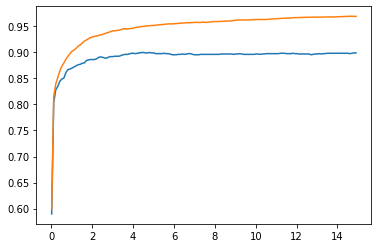

In [ ]:
validation_curve_function(SVC(), x_train, y_train, "C", np.arange(0.01,15,0.1))

91.7% success rate.

#Random Forest


##All classes

In [22]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [23]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [25]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 1000], "max_features" : ['sqrt', 'log2']}

In [26]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.82332155 0.85865724 0.80918728 0.82685512 0.86170213]


In [27]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [28]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.809 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.809 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.774 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.795 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.840 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.823 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.866 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.820 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.823 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.865 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=1000;, score=0.823 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=1000;, score=0.862 total time=   2.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=1000;, score=0.806 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=1000;, score=0.834 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=1000;, score=0.862 total time=   2.5s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.792 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.813 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.770 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.806 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.823 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.830 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=100;, score=0.869 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=100;, score=0.816 total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.834 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.858 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=1000;, score=0.830 total time=   5.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=1000;, score=0.855 total time=   5.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=1000;, score=0.813 total time=   8.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=1000;, score=0.845 total time=   7.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=1000;, score=0.865 total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             verbose=4)

In [29]:
grid_search.best_params_

{'max_features': 'log2', 'n_estimators': 1000}

In [30]:
RF = RandomForestClassifier(max_features = grid_search.best_params_["max_features"], n_estimators = grid_search.best_params_["n_estimators"])
model_RF = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [31]:
pred = model_RF.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         115
Obesity_Type_III       105
Obesity_Type_II        105
Overweight_Level_II     98
Normal_Weight           97
Overweight_Level_I      93
Insufficient_Weight     84
dtype: int64

In [32]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_all

82.20946915351506

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

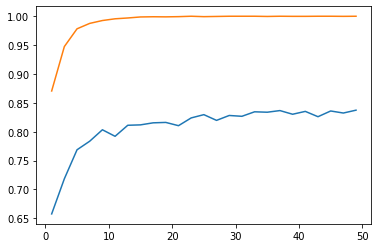

In [33]:
validation_curve_function(RandomForestClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

##Binary classification

In [ ]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
RF = RandomForestClassifier()
parameters={"n_estimators" : [10, 100, 1000], "max_features" : ['sqrt', 'log2']}

In [ ]:
cross_val_function(RF, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[0.93639576 0.92226148 0.90106007 0.93286219 0.91489362]


In [ ]:
grid_search = GridSearchCV(estimator=RF,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=sqrt, n_estimators=10;, score=0.905 total time=   0.0s
[CV 2/5] END max_features=sqrt, n_estimators=10;, score=0.908 total time=   0.0s
[CV 3/5] END max_features=sqrt, n_estimators=10;, score=0.908 total time=   0.0s
[CV 4/5] END max_features=sqrt, n_estimators=10;, score=0.922 total time=   0.0s
[CV 5/5] END max_features=sqrt, n_estimators=10;, score=0.890 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=sqrt, n_estimators=100;, score=0.936 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=100;, score=0.919 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=100;, score=0.894 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=100;, score=0.922 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=100;, score=0.929 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=sqrt, n_estimators=1000;, score=0.940 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=sqrt, n_estimators=1000;, score=0.929 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=sqrt, n_estimators=1000;, score=0.905 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=sqrt, n_estimators=1000;, score=0.929 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=sqrt, n_estimators=1000;, score=0.922 total time=   2.5s
[CV 1/5] END max_features=log2, n_estimators=10;, score=0.919 total time=   0.0s
[CV 2/5] END max_features=log2, n_estimators=10;, score=0.912 total time=   0.0s
[CV 3/5] END max_features=log2, n_estimators=10;, score=0.880 total time=   0.0s
[CV 4/5] END max_features=log2, n_estimators=10;, score=0.915 total time=   0.0s
[CV 5/5] END max_features=log2, n_estimators=10;, score=0.887 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

[CV 1/5] END max_features=log2, n_estimators=100;, score=0.940 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=100;, score=0.915 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=100;, score=0.894 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=100;, score=0.933 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=100;, score=0.915 total time=   0.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/5] END max_features=log2, n_estimators=1000;, score=0.943 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/5] END max_features=log2, n_estimators=1000;, score=0.919 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/5] END max_features=log2, n_estimators=1000;, score=0.898 total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 4/5] END max_features=log2, n_estimators=1000;, score=0.929 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 5/5] END max_features=log2, n_estimators=1000;, score=0.926 total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             verbose=4)

In [ ]:
grid_search.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [ ]:
RF = RandomForestClassifier(max_features = grid_search.best_params_["max_features"], n_estimators = grid_search.best_params_["n_estimators"])
model = RF.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Not obese    365
Obese        332
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_rf_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_rf_bin

94.97847919655668

#Boosting

##All classes

In [ ]:
df = pd.read_csv(url)
df.dropna(inplace=True)

col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]
df.columns = col_names

df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
df["Age"] = df["Age"].apply(lambda x : int(float(int(x*100))/100))
df["Height"] = df["Height"].apply(lambda x : round(x,2))
df["Weight"] = df["Weight"].apply(lambda x : round(x,1))
df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
df["FCVC"] = df["FCVC"].apply(lambda x : int(round(x,0)))
df["NCP"] = df["NCP"].apply(lambda x : int(round(x,0)))
df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
df["CH2O"] = df["CH2O"].apply(lambda x : round(x,1))
df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
df["FAF"] = df["FAF"].apply(lambda x : int(round(x,0)))
df["TUE"] = df["TUE"].apply(lambda x : round(x,2))
df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

df.drop(['Weight'],axis = 1, inplace = True)
df.drop(['Smoke'],axis = 1, inplace = True)

In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 1000], "learning_rate" : [0.001, 0.01, 0.1]} #, "subsample" : [0.5, 0.7, 1.0], "max_depth" : [3, 7, 9]}

In [ ]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[0.82685512 0.80565371 0.78091873 0.79858657 0.83333333]


In [ ]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=10;, score=0.177 total time=   0.2s
[CV 3/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=10;, score=0.173 total time=   0.2s
[CV 5/5] END learning_rate=0.001, n_estimators=10;, score=0.174 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.530 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.516 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.516 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.527 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.539 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, n_estimators=1000;, score=0.654 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, n_estimators=1000;, score=0.664 total time=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, n_estimators=1000;, score=0.686 total time=  15.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, n_estimators=1000;, score=0.664 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, n_estimators=1000;, score=0.663 total time=  15.4s
[CV 1/5] END learning_rate=0.01, n_estimators=10;, score=0.530 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=10;, score=0.519 total time=   0.2s
[CV 3/5] END learning_rate=0.01, n_estimators=10;, score=0.523 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=10;, score=0.527 total time=   0.2s
[CV 5/5] END learning_rate=0.01, n_estimators=10;, score=0.543 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.654 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=100;, score=0.664 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=100;, score=0.689 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=100;, score=0.664 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=100;, score=0.663 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, n_estimators=1000;, score=0.841 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, n_estimators=1000;, score=0.799 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, n_estimators=1000;, score=0.784 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, n_estimators=1000;, score=0.806 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, n_estimators=1000;, score=0.823 total time=  15.1s
[CV 1/5] END learning_rate=0.1, n_estimators=10;, score=0.654 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=10;, score=0.657 total time=   0.2s
[CV 3/5] END learning_rate=0.1, n_estimators=10;, score=0.682 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=10;, score=0.657 total time=   0.2s
[CV 5/5] END learning_rate=0.1, n_estimators=10;, score=0.663 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=100;, score=0.827 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=100;, score=0.806 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=100;, score=0.784 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=100;, score=0.799 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=100;, score=0.826 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, n_estimators=1000;, score=0.845 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, n_estimators=1000;, score=0.806 total time=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, n_estimators=1000;, score=0.809 total time=  15.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, n_estimators=1000;, score=0.809 total time=  15.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, n_estimators=1000;, score=0.837 total time=  15.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'n_estimators': [10, 100, 1000]},
             verbose=4)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

In [ ]:
boost = GradientBoostingClassifier(learning_rate = grid_search.best_params_["learning_rate"], n_estimators = grid_search.best_params_["n_estimators"])
model = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Obesity_Type_I         119
Obesity_Type_III       109
Normal_Weight          108
Obesity_Type_II        106
Overweight_Level_I      91
Overweight_Level_II     83
Insufficient_Weight     81
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_all = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_all

82.06599713055954

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

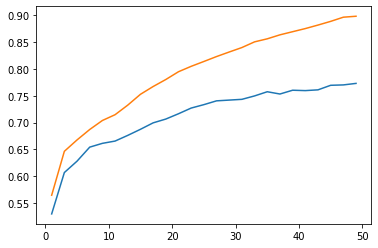

In [ ]:
validation_curve_function(GradientBoostingClassifier(), x_train, y_train, "n_estimators", np.arange(1,50,2))

##Binary Classification

In [ ]:
obesity_level ={"Insufficient_Weight": "Not obese", "Normal_Weight": "Not obese", "Overweight_Level_I": "Not obese", "Overweight_Level_II": "Not obese", "Obesity_Type_I": "Obese", "Obesity_Type_II": "Obese", "Obesity_Type_III": "Obese"}

df["Obesity_level_category"] = df["Obesity_level_category"].map(obesity_level,na_action='ignore').apply(lambda x : str(x))

In [ ]:
x=df.loc[:,df.columns!="Obesity_level_category"]
y=df.loc[:,df.columns=="Obesity_level_category"]

scaler=StandardScaler()
scaler.fit(x)
x_scaled=scaler.transform(x)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.33)

In [ ]:
boost = GradientBoostingClassifier()
parameters={"n_estimators" : [10, 100, 1000], "learning_rate" : [0.001, 0.01, 0.1], "subsample" : [0.5, 0.7, 1.0], "max_depth" : [3, 7, 9]}

In [ ]:
cross_val_function(boost, x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[0.86925795 0.86219081 0.92226148 0.86219081 0.90425532]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
grid_search = GridSearchCV(estimator=boost,
                           param_grid=parameters,
                           cv=5,
                           verbose=4)

In [ ]:
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.5;, score=0.543 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=0.7;, score=0.543 total time=   0.0s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=10, subsample=1.0;, score=0.543 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.544 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.544 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.5;, score=0.543 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.544 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.544 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=0.7;, score=0.543 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.544 total time=   0.2s
[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.544 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.544 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=100, subsample=1.0;, score=0.543 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.799 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.788 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.827 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.784 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.812 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.799 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.788 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.823 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.781 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.801 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.788 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.792 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.813 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.806 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.780 total time=   1.7s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.5;, score=0.543 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=0.7;, score=0.543 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=10, subsample=1.0;, score=0.543 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.608 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.594 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.608 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.618 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.5;, score=0.574 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.629 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.594 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.608 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.625 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=0.7;, score=0.585 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.618 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.544 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.583 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.640 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=100, subsample=1.0;, score=0.543 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.883 total time=   4.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.887 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.926 total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.873 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.926 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.898 total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.883 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.929 total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.862 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.918 total time=   4.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.880 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.855 total time=   4.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.898 total time=   4.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.855 total time=   4.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.887 total time=   4.8s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.5;, score=0.543 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s
[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.1s
[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=0.7;, score=0.543 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s
[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s
[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=10, subsample=1.0;, score=0.543 total time=   0.1s
[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.682 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.689 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.696 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.686 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.5;, score=0.667 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.710 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.739 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.700 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.700 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=0.7;, score=0.695 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.788 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.834 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.767 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.678 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=100, subsample=1.0;, score=0.688 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.919 total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.905 total time=   7.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.951 total time=   7.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.887 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.957 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.919 total time=   7.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.908 total time=   8.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.947 total time=   8.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.890 total time=   8.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.961 total time=   8.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.876 total time=   6.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.887 total time=   5.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.915 total time=   6.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.869 total time=   5.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.001, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.943 total time=   6.7s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.5;, score=0.543 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7;, score=0.543 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=10, subsample=1.0;, score=0.543 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.792 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.792 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.841 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.795 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5;, score=0.830 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.792 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.781 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.820 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.788 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.798 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.792 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.792 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.813 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.806 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=0.780 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.866 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.866 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.929 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.869 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.894 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.866 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.859 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.919 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.862 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.908 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.862 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.869 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.926 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.869 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.911 total time=   1.7s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.629 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.622 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.608 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.657 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.5;, score=0.617 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.629 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.544 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.615 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.629 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=0.7;, score=0.582 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.618 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.544 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.583 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.640 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=10, subsample=1.0;, score=0.543 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.873 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.887 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.919 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.880 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.5;, score=0.922 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.894 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.873 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.926 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.873 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.7;, score=0.904 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.880 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.855 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.901 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.848 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=0.890 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.926 total time=   4.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.919 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.961 total time=   4.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.905 total time=   4.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.961 total time=   4.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.929 total time=   5.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.915 total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.968 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.922 total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.965 total time=   5.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.919 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.908 total time=   5.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.947 total time=   5.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.915 total time=   5.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.954 total time=   5.5s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.739 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.746 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.735 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.721 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.5;, score=0.699 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.689 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.731 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.742 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.731 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=0.7;, score=0.755 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.788 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.834 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.767 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.678 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=10, subsample=1.0;, score=0.684 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.915 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.901 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.943 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.887 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5;, score=0.950 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.912 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.908 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.936 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.866 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7;, score=0.954 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.876 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.890 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.912 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.869 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0;, score=0.943 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.929 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.926 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.958 total time=   7.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.912 total time=   7.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.965 total time=   7.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.926 total time=   8.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.929 total time=   8.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.965 total time=   9.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.919 total time=   8.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.965 total time=   9.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.922 total time=   9.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.926 total time=  10.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.961 total time=   9.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.901 total time=   9.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.01, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.957 total time=   9.8s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.767 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.756 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.820 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.802 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.5;, score=0.812 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.774 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.792 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.802 total time=   0.0s
[CV 4/5] END lea

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=0.7;, score=0.805 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.792 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.792 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.816 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.781 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=10, subsample=1.0;, score=0.784 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.859 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.852 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.912 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.869 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5;, score=0.911 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.876 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.862 total time=   0.2s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.933 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.862 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7;, score=0.918 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.869 total time=   0.2s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.862 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.922 total time=   0.2s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.866 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=0.904 total time=   0.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.898 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.894 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.933 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.894 total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.5;, score=0.950 total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.912 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.898 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.954 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.898 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=0.7;, score=0.940 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.922 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.890 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.954 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.912 total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=1000, subsample=1.0;, score=0.947 total time=   1.7s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.898 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.876 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.901 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.852 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.5;, score=0.876 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.869 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.859 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.922 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.845 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=0.7;, score=0.869 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.880 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.866 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.922 total time=   0.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.852 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=10, subsample=1.0;, score=0.876 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.926 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.908 total time=   0.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.947 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.905 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.5;, score=0.965 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.922 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.926 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.965 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.919 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.961 total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.908 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.912 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.968 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.908 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=0.950 total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.929 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.926 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.954 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.929 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.5;, score=0.961 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.922 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.922 total time=   3.3s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.961 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.922 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=0.7;, score=0.961 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.929 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.922 total time=   3.2s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.965 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.919 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=7, n_estimators=1000, subsample=1.0;, score=0.965 total time=   3.5s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.905 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.880 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.929 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.869 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.5;, score=0.926 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.908 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.905 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.919 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.898 total time=   0.1s
[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=0.7;, score=0.950 total time=   0.1s
[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.883 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.873 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.908 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.866 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=10, subsample=1.0;, score=0.940 total time=   0.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.922 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.929 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.954 total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.919 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5;, score=0.968 total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.926 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.915 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.958 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.926 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7;, score=0.972 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.919 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.922 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.954 total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.908 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0;, score=0.954 total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.936 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.929 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.951 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.919 total time=   4.0s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.5;, score=0.961 total time=   4.1s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.926 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.922 total time=   3.7s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.961 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.919 total time=   3.8s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=0.7;, score=0.968 total time=   3.9s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.929 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.929 total time=   3.4s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.958 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.919 total time=   3.5s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END learning_rate=0.1, max_depth=9, n_estimators=1000, subsample=1.0;, score=0.968 total time=   3.6s


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 7, 9],
                         'n_estimators': [10, 100, 1000],
                         'subsample': [0.5, 0.7, 1.0]},
             verbose=4)

In [ ]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}

In [ ]:
boost = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 9, subsample = 0.7)
model = boost.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(x_test)
pd.Series(pred).value_counts()

Not obese    366
Obese        331
dtype: int64

In [ ]:
pred = pd.DataFrame(pred)
pred.columns=y_test.columns

accuracy = np.where(pred.reset_index(drop=True)==y_test.reset_index(drop=True), 1, 0)
df_result_pred_test = pd.DataFrame(accuracy)
df_result_pred_test.columns = ["result"]

res_boost_bin = 100*df_result_pred_test["result"].value_counts()[1]/len(df_result_pred_test["result"])
res_boost_bin

93.68723098995696

#Comparaison of the models

In [ ]:
res_all = [res_lda_all, res_knn_all, res_svm_all, res_rf_all, res_boost_all]
res_bin = [res_lda_bin, res_knn_bin, res_svm_bin, res_rf_bin, res_boost_bin]
results = np.array([res_all, res_bin])

names_models = ["Linear Discriminant Analysis","Knn","SVM","Random Forest","Boosting"]
compare_models = pd.DataFrame(results, index=["All classes","Binary Classification"], columns = names_models)
compare_models

,Linear Discriminant Analysis,Knn,SVM,Random Forest,Boosting
All classes,55.380201,80.057389,80.631277,87.374462,82.065997
Binary Classification,71.736011,93.400287,91.104735,94.978479,93.687231


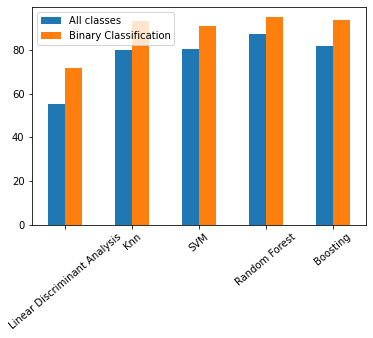

In [ ]:
compare_models.T.plot(kind="bar",rot=40)

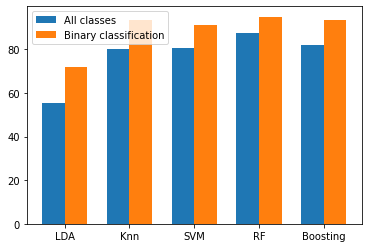

In [ ]:
position = np.arange(len(names_models))
largeur=0.35

fig, ax = plt.subplots()
r1 = ax.bar(position - largeur/2, res_all, width = largeur)
r2 = ax.bar(position + largeur/2, res_bin, width = largeur)

# Modification des marques sur l'axe des x et de leurs étiquettes
ax.set_xticks(position)
ax.set_xticklabels(["LDA","Knn","SVM","RF","Boosting"])
ax.legend(["All classes","Binary classification"])

#Flask

##Conversion des informations input, sous forme d'un dataframe conforme aux différents modèles 

Voici, une fonction qui nous permet de transformer les données issues du formulaire sur la page web, en données prêtes à être envoyé dans la fonction de prédiction de nos différents modèlesd eMachine Learning.

In [36]:
def Create_data_for_prediction(data):
  col_names = ["Gender", "Age", "Height", "Weight", "Family_overweight", "FAVC", "FCVC", "NCP", "CAEC", "Smoke", "CH2O", "SCC", "FAF", "TUE", "CALC", "Transportation", "Obesity_level_category"]

  df = pd.DataFrame([data],columns=col_names)

  df["Gender"] = df["Gender"].apply(lambda x : 1 if x=="Female" else 0)
  df["Age"] = df["Age"].apply(lambda x : int(x))
  df["Height"] = df["Height"].apply(lambda x : round(float(x),2))
  df["Weight"] = df["Weight"].apply(lambda x : round(float(x),1))
  df["Family_overweight"] = df["Family_overweight"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAVC"] = df["FAVC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FCVC"] = df["FCVC"].apply(lambda x : int(round(int(x),0)))
  df["NCP"] = df["NCP"].apply(lambda x : int(round(int(x),0)))
  df["CAEC"], unique_CAEC = pd.factorize(df["CAEC"], sort=True)
  df["Smoke"] = df["Smoke"].apply(lambda x : 1 if x=="yes" else 0)
  df["CH2O"] = df["CH2O"].apply(lambda x : round(int(x),1))
  df["SCC"] = df["SCC"].apply(lambda x : 1 if x=="yes" else 0)
  df["FAF"] = df["FAF"].apply(lambda x : int(round(int(x),0)))
  df["TUE"] = df["TUE"].apply(lambda x : round(int(x),2))
  df["CALC"], unique_CALC = pd.factorize(df["CALC"], sort=True)

  transportation ={"Automobile": 1, "Bike": 2, "Motorbike": 3, "Public_Transportation": 4, "Walking": 5}

  df["Transportation"] = df["Transportation"].map(transportation,na_action='ignore').apply(lambda x : int(x))

  df['Transportation']=np.where(df['Transportation']==1,0,df['Transportation']) #Automobile
  df['Transportation']=np.where(df['Transportation']==3,0,df['Transportation']) #Motorbike
  df['Transportation']=np.where(df['Transportation']==4,0,df['Transportation']) #Public transportation

  df['Transportation']=np.where(df['Transportation']==2,1,df['Transportation']) #Bike
  df['Transportation']=np.where(df['Transportation']==5,1,df['Transportation']) #Walking

  df.drop(['Weight'],axis = 1, inplace = True)
  df.drop(['Smoke'],axis = 1, inplace = True)

  x=df.loc[:,df.columns!="Obesity_level_category"]

  scaler=StandardScaler()
  scaler.fit(x)
  x_scaled=scaler.transform(x)

  return x_scaled 

##Pip install and packages

In [37]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 22jg9dgfJ2Vrf9hIs8I8fppLe24_4vre3wAhAg3T7F9ArM2Nr

  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15984 sha256=82399ce58f9da2be97bd69e20c74e9de769859f60397c94e9051491e6c3c0bb8
  Stored in directory: /root/.cache/pip/wheels/b1/d9/12/045a042fee3127dc40ba6f5df2798aa2df38c414bf533ca765
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [38]:
import pickle
from os import name
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, redirect, url_for

Sauvegarde de nos modèles au format .pkl pour l'application Flask

In [39]:
pickle.dump(model_RF, open('model_RF.pkl','wb'))

##App

In [41]:
app = Flask(__name__, template_folder='/content', static_folder='/content/static')

run_with_ngrok(app)

model = pickle.load(open('/content/model_RF.pkl', 'rb'))



@app.route('/')
def home():
    return render_template("index.html")

@app.route('/getprediction',methods=['POST'])
def getprediction():    

    input = [x for x in request.form.values()]
    input.append("")

    x = Create_data_for_prediction(input)

    prediction = model.predict(x)

    return render_template("index.html", output='Predicted obesity level category : {}'.format(prediction))

app.run()


if __name__ == "__main__":
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e66c-34-66-15-212.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [26/Dec/2021 17:58:41] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:58:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:58:43] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:58:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:58:45] "GET /static/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:58:48] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [26/Dec/2021 17:59:30] "POST /getprediction HTTP/1.1" 200 -
127.0.0.1 - - [26/Dec/2021 17:59:31] "GET /getprediction HTTP/1.1" 405 -


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
